<a href="https://colab.research.google.com/github/asdfasdf001234/2024-1-MLPRJ/blob/main/ConvNeXt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns
from torchvision import models
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split
from PIL import Image
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### https://github.com/davda54/sam

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [3]:
data_path = "drive/MyDrive/Data"

In [4]:
import random

def set_random_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

# Set a random seed value
seed_value = 42
set_random_seed(seed_value)


In [5]:
def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
      file_name = os.path.splitext(os.path.basename(img))[0]
      label_index = int(file_name[0]) - 1
      if label_index == 0 or label_index == 2:   #웜톤
        label_index = 0                          #0으로 통일
      else:                                      #쿨톤
        label_index = 1                          #1으로 통일
      if 0 <= label_index < len(label_list):
        label = label_list[label_index]
        new_data = pd.DataFrame({"path": [img], "label": [label], "class_id": [label_index]})
        df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [6]:
# train_path = data_path + '/train/train/'
# valid_path = data_path + '/val/val/'
# test_path = data_path + '/test/test/'
# label_list = ['spring', 'summer', 'autumn', 'winter']

# train_df = create_dataframe(train_path, label_list, 'training')
# val_df = create_dataframe(valid_path, label_list, 'validation')
# test_df = create_dataframe(test_path, label_list, 'test')

In [7]:
train_path = data_path + '/train/'
valid_path = data_path + '/val/'
test_path = data_path + '/test/'
label_list = ['warm', 'cool']

train_df = create_dataframe(train_path, label_list, 'train')
val_df = create_dataframe(valid_path, label_list, 'valid')
test_df = create_dataframe(test_path, label_list, 'test')

In [8]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 446
val_data:137
test_data:104


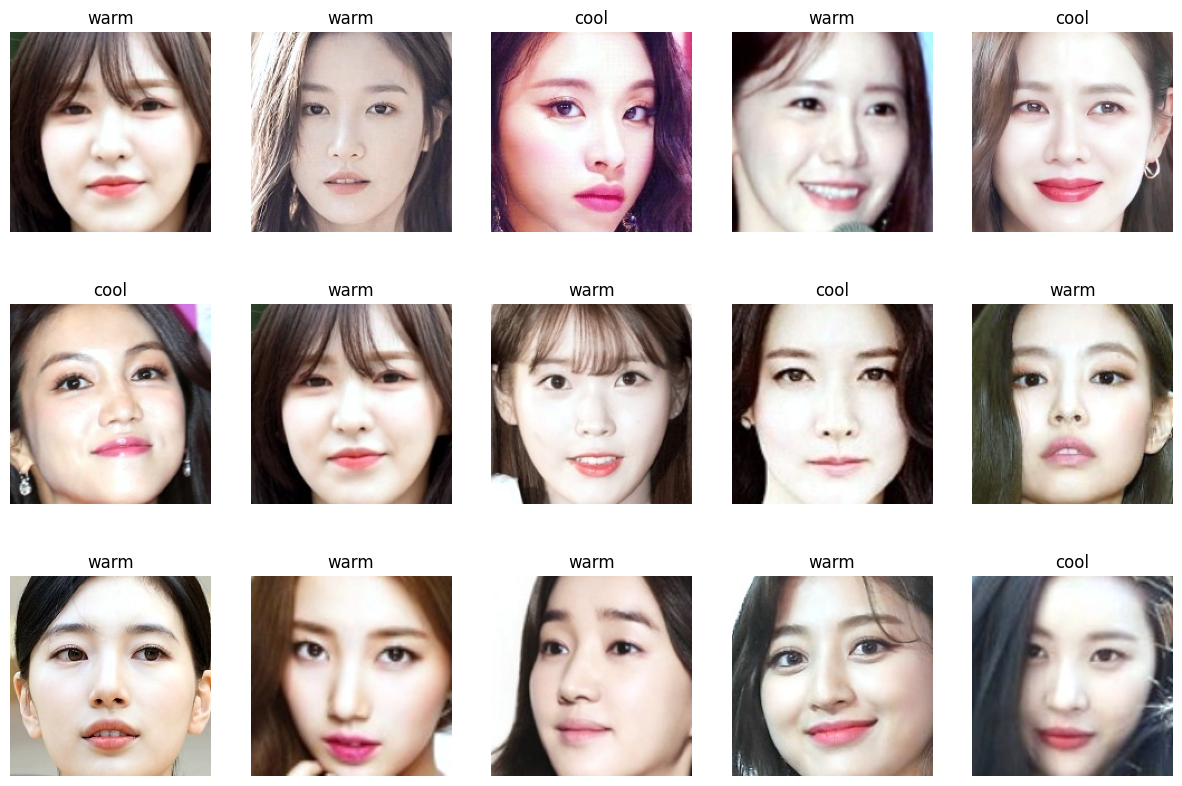

In [9]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [10]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [11]:
Transforms = v2.Compose([
    #===============================#
    #v2.RandomResizedCrop(size=(224,224), antialias=True), # image 크기 맞추기
    v2.Resize((224,224)),
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomRotation(degrees=10),
    v2.RandomHorizontalFlip(p=0.8),
    #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    #v2.ElasticTransform(alpha=250.0),
    #v2.ScaleJitter(target_size=(224,224)),
    v2.RandomAffine(degrees=45),
    #v2.ColorJitter(),
    #===============================#
    ]) # dtype 변환

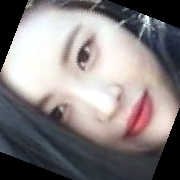

In [12]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


In [13]:
#get dataloader
BATCH_SIZE = 32
train_dataset = BaseDataset(train_df , Transforms) # train_transforms
val_dataset = BaseDataset(val_df , Transforms)
test_dataset = BaseDataset(test_df , Transforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
convnext = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:04<00:00, 73.6MB/s]


In [16]:
print(convnext)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [17]:
import torch.nn as nn

In [28]:
class MyConvNeXt(nn.Module):
    def __init__(self, pretrained_model):
        super(MyConvNeXt, self).__init__()
        self.backbone = nn.Sequential(*list(pretrained_model.children())[:-1])
        #self.backbone = pretrained_model

        for param in self.backbone.parameters():
            param.requires_grad = True

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 1)
        #self.fc3 = nn.Linear(256, 1)

        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x


In [29]:
myconvnext = MyConvNeXt(convnext)

In [30]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        size += data_.size(0)

        # GPU에 올리기
        data, target = data_.to(device), target_.to(device)
        target = target.unsqueeze(1).float()

        # 첫번째 SAM
        pred = model(data)
        loss = loss_fn(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.first_step(zero_grad=True)

        # 두번째 SAM
        loss_fn(model(data), target).backward()
        optimizer.second_step(zero_grad=True)

        epoch_loss += loss.item()

        predicted = (pred >= 0.5).float()
        epoch_correct += (predicted == target).sum().item()

    train_acc = epoch_correct / size
    lr_scheduler.step()

    return train_acc , epoch_loss / num_batches


def test(dataloader , model , loss_fn):
    size = 0
    num_batches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0

    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시

        for i, (data_ , target_) in enumerate(dataloader):

            size += data_.size(0)

            # GPU에 올리기
            data, target = data_.to(device), target_.to(device)
            target = target.unsqueeze(1).float()

            # prediction, loss 계산
            pred = model(data)
            loss = loss_fn(pred, target)

            epoch_loss += loss.item()

            predicted = (pred >= 0.5).float()
            epoch_correct += (predicted == target).sum().item()

    test_acc = epoch_correct / size

    return test_acc  , epoch_loss / num_batches

In [31]:
myconvnext.cuda()

MyConvNeXt(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm

In [32]:
import torch
from torchvision import datasets, transforms
# 클래스별 데이터 개수 확인
class_counts = torch.zeros(2, dtype=torch.float)

for _, label in train_dataset:
    class_counts[label] += 1

class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.cuda()
print("Class counts:", class_weights)

Class counts: tensor([0.6300, 0.3700], device='cuda:0')


In [33]:
seed_value = 42
set_random_seed(seed_value)

EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

base_optimizer = optim.AdamW
optimizer = SAM(myconvnext.parameters(), base_optimizer, lr=1e-4, weight_decay=0.9)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer.base_optimizer, T_max=100)

patience = 10
counter = 0
best_loss = np.inf

In [34]:
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader,
                                  myconvnext,
                                  criterion,
                                  optimizer,
                                  lr_scheduler)

    val_acc, val_loss = test(val_loader, myconvnext, criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f}, train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myconvnext.state_dict(), "checkpoints/myconvnext_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stop!")
        break

test_acc, test_loss = test(test_loader, myconvnext, criterion)
print(f'test_acc: {test_acc}, test_loss: {test_loss}')


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 0.6689, train_acc:0.6121     val_loss = 0.6933, val_acc:0.6350     learning rate: 9.997532801828658e-05


  1%|          | 1/100 [00:14<24:21, 14.76s/it]

epoch:1     train_loss = 0.6622, train_acc:0.6300     val_loss = 0.6875, val_acc:0.6350     learning rate: 9.990133642141359e-05


  2%|▏         | 2/100 [00:30<24:51, 15.22s/it]

epoch:2     train_loss = 0.6663, train_acc:0.6278     val_loss = 0.6854, val_acc:0.6350     learning rate: 9.977809823015401e-05


  4%|▍         | 4/100 [00:59<23:31, 14.71s/it]

epoch:3     train_loss = 0.6487, train_acc:0.6300     val_loss = 0.6906, val_acc:0.6350     learning rate: 9.960573506572391e-05
epoch:4     train_loss = 0.6475, train_acc:0.6300     val_loss = 0.6741, val_acc:0.6350     learning rate: 9.93844170297569e-05


  5%|▌         | 5/100 [01:14<23:16, 14.70s/it]

epoch:5     train_loss = 0.6362, train_acc:0.6300     val_loss = 0.6732, val_acc:0.6350     learning rate: 9.911436253643445e-05


  7%|▋         | 7/100 [01:44<22:53, 14.77s/it]

epoch:6     train_loss = 0.6329, train_acc:0.6300     val_loss = 0.6823, val_acc:0.6350     learning rate: 9.879583809693738e-05
epoch:7     train_loss = 0.6162, train_acc:0.6368     val_loss = 0.6567, val_acc:0.6350     learning rate: 9.842915805643157e-05


  8%|▊         | 8/100 [01:58<22:24, 14.62s/it]

epoch:8     train_loss = 0.6046, train_acc:0.6390     val_loss = 0.6506, val_acc:0.6934     learning rate: 9.801468428384717e-05


 10%|█         | 10/100 [02:27<21:46, 14.51s/it]

epoch:9     train_loss = 0.6307, train_acc:0.6682     val_loss = 0.6643, val_acc:0.6350     learning rate: 9.75528258147577e-05
epoch:10     train_loss = 0.5991, train_acc:0.6570     val_loss = 0.6356, val_acc:0.7007     learning rate: 9.70440384477113e-05


 11%|█         | 11/100 [02:41<21:27, 14.46s/it]

epoch:11     train_loss = 0.5811, train_acc:0.6839     val_loss = 0.6114, val_acc:0.6861     learning rate: 9.64888242944126e-05


 13%|█▎        | 13/100 [03:10<20:56, 14.44s/it]

epoch:12     train_loss = 0.5833, train_acc:0.6726     val_loss = 0.6218, val_acc:0.7007     learning rate: 9.588773128419907e-05
epoch:13     train_loss = 0.5475, train_acc:0.7108     val_loss = 0.6011, val_acc:0.7518     learning rate: 9.5241352623301e-05


 14%|█▍        | 14/100 [03:24<20:35, 14.37s/it]

epoch:14     train_loss = 0.5323, train_acc:0.7377     val_loss = 0.5750, val_acc:0.7518     learning rate: 9.455032620941843e-05


 15%|█▌        | 15/100 [03:38<20:15, 14.30s/it]

epoch:15     train_loss = 0.4935, train_acc:0.7601     val_loss = 0.5694, val_acc:0.7153     learning rate: 9.381533400219321e-05


 17%|█▋        | 17/100 [04:07<19:46, 14.30s/it]

epoch:16     train_loss = 0.4682, train_acc:0.8004     val_loss = 0.5731, val_acc:0.7445     learning rate: 9.303710135019722e-05


 18%|█▊        | 18/100 [04:20<19:09, 14.02s/it]

epoch:17     train_loss = 0.4206, train_acc:0.8049     val_loss = 0.6486, val_acc:0.7372     learning rate: 9.22163962751008e-05


 19%|█▉        | 19/100 [04:34<18:38, 13.81s/it]

epoch:18     train_loss = 0.4150, train_acc:0.8117     val_loss = 0.5976, val_acc:0.7080     learning rate: 9.135402871372814e-05


 20%|██        | 20/100 [04:47<18:09, 13.62s/it]

epoch:19     train_loss = 0.4086, train_acc:0.8184     val_loss = 0.6136, val_acc:0.7445     learning rate: 9.045084971874742e-05
epoch:20     train_loss = 0.3590, train_acc:0.8655     val_loss = 0.5389, val_acc:0.7299     learning rate: 8.950775061878456e-05


 22%|██▏       | 22/100 [05:16<18:19, 14.10s/it]

epoch:21     train_loss = 0.3084, train_acc:0.8834     val_loss = 0.6725, val_acc:0.7445     learning rate: 8.852566213878951e-05


 23%|██▎       | 23/100 [05:30<17:59, 14.02s/it]

epoch:22     train_loss = 0.2891, train_acc:0.8857     val_loss = 0.7862, val_acc:0.7080     learning rate: 8.750555348152303e-05


 24%|██▍       | 24/100 [05:44<17:40, 13.96s/it]

epoch:23     train_loss = 0.3034, train_acc:0.8834     val_loss = 0.7266, val_acc:0.7007     learning rate: 8.644843137107063e-05


 25%|██▌       | 25/100 [05:57<17:20, 13.87s/it]

epoch:24     train_loss = 0.2330, train_acc:0.9103     val_loss = 0.7930, val_acc:0.7153     learning rate: 8.535533905932742e-05


 26%|██▌       | 26/100 [06:11<16:59, 13.78s/it]

epoch:25     train_loss = 0.1912, train_acc:0.9350     val_loss = 0.6579, val_acc:0.7226     learning rate: 8.422735529643448e-05


 27%|██▋       | 27/100 [06:24<16:40, 13.70s/it]

epoch:26     train_loss = 0.1711, train_acc:0.9350     val_loss = 0.7657, val_acc:0.7007     learning rate: 8.306559326618263e-05


 28%|██▊       | 28/100 [06:38<16:20, 13.62s/it]

epoch:27     train_loss = 0.1566, train_acc:0.9507     val_loss = 0.8186, val_acc:0.7007     learning rate: 8.187119948743452e-05


 29%|██▉       | 29/100 [06:51<16:02, 13.56s/it]

epoch:28     train_loss = 0.1444, train_acc:0.9484     val_loss = 1.0409, val_acc:0.7226     learning rate: 8.064535268264887e-05


 30%|███       | 30/100 [07:04<15:44, 13.50s/it]

epoch:29     train_loss = 0.1393, train_acc:0.9529     val_loss = 0.8831, val_acc:0.7372     learning rate: 7.938926261462371e-05


 30%|███       | 30/100 [07:18<17:02, 14.61s/it]

epoch:30     train_loss = 0.1169, train_acc:0.9507     val_loss = 1.0815, val_acc:0.7080     learning rate: 7.810416889260659e-05
Early stop!


test_acc: 0.7596153846153846, test_loss: 1.0053130947053432
